# Autoencoder demonstration of Fisher metric pruning:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
import autoencoder

/var/folders/91/t5gt4nr502vgy7gsbqgd47wm0000gn/T/ipykernel_596/1800734416.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Train a degenerate autoencoder
__256 hidden neurons in latent space__

In [2]:
model = autoencoder.MNISTModel(latent_dim=20)
model.train()

Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Completed training successfully...


## Testing
__(check the performance of the encoder)__

In [3]:
# Define a transform to map from image to pixel floats
transform = transforms.Compose([transforms.ToTensor(), torch.flatten])

# Create testing dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

# Create testing dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=10, shuffle=True
)


In [4]:
import matplotlib.pyplot as plt

def plot_batch(images, filename):
    # Plot the batch of images
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].view(28, 28).detach().numpy(), cmap='gray')
        # plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [5]:
# Get a batch of images
iterator = iter(test_dataloader)
batches = next(iterator)
batch_0 = batches[0]

### Original images

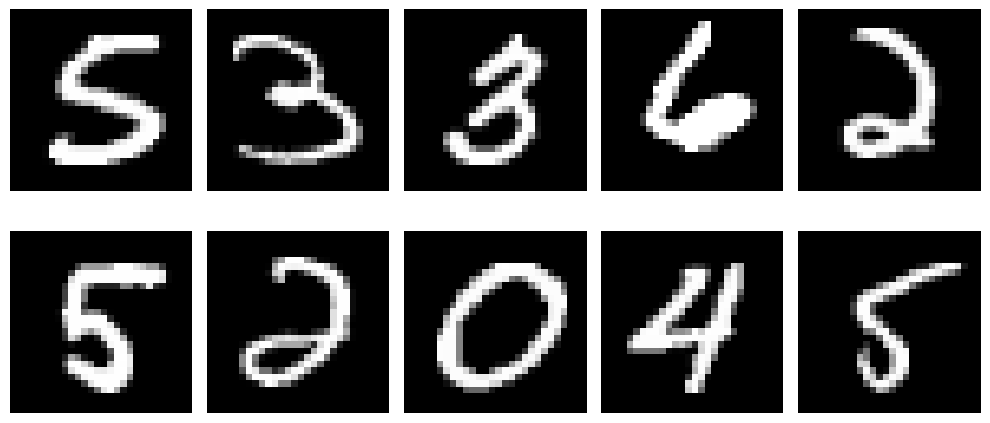

In [6]:
plot_batch(batch_0, filename='plots/original_samples.pdf')

In [7]:
autoencoded_batch = [model.autoencoder(batch_0[i]) for i in range(10)]

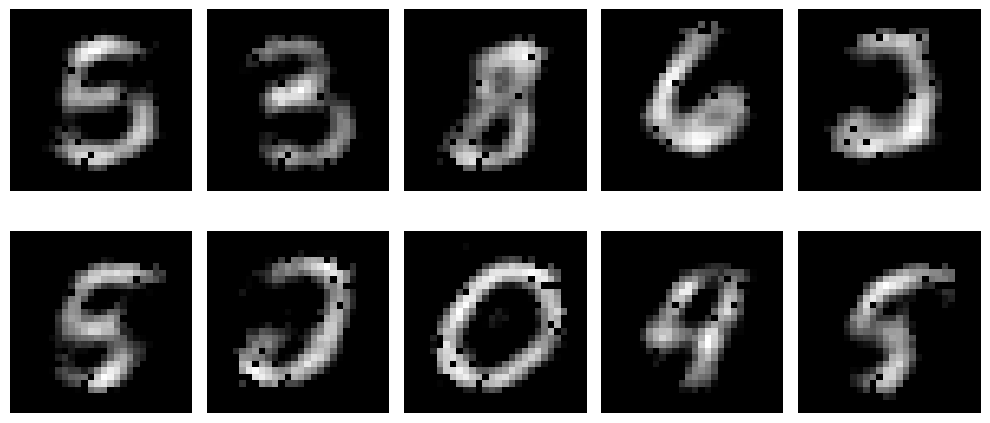

In [8]:
plot_batch(autoencoded_batch, 'plots/autoencoded_no_pruning.pdf')
# autoencoded_batch[0].shape

## Diagonal Fisher matrix element distribution

In [9]:
import fisher_transform
# Define the FIM
fim = fisher_transform.find_fisher(model.autoencoder, test_dataloader,
                                   n_output=784)


Autoencoder(
  (encoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=784, bias=True)
    (1): ReLU()
  )
)


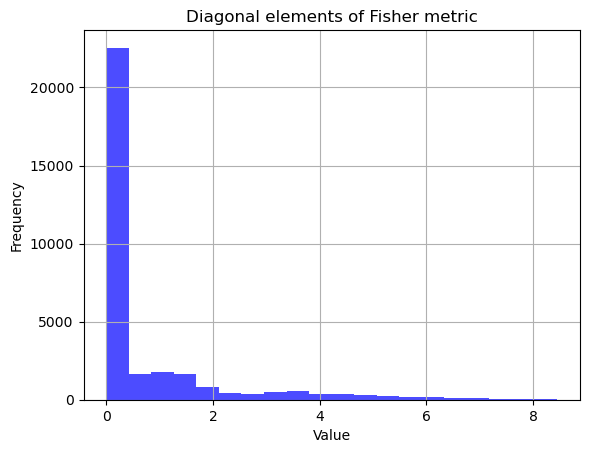

Mean diagonal FIM entry:  tensor(0.7148)


In [19]:
# Distribution of diagonal elements of FIM

# Plot the histogram
plt.hist(fim, bins=20, color='blue', alpha=0.7)
plt.title('Diagonal elements of Fisher metric')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('plots/hist_diag_elmts.pdf')
plt.show()


print('Mean diagonal FIM entry: ', fim.mean())

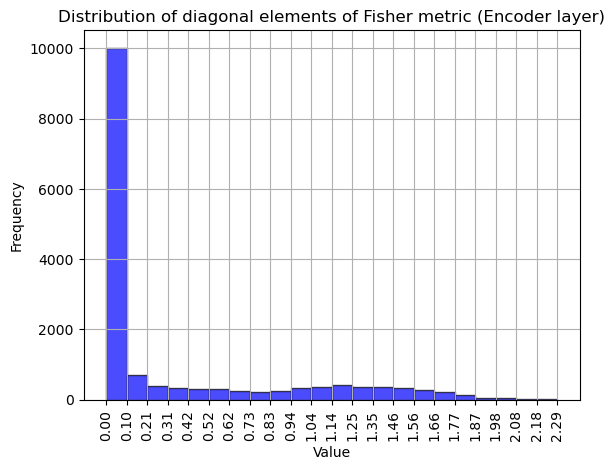

In [68]:

import numpy as np

 # Calculate the histogram without plotting it to get the bin edges
no_bins = 22
hist, bin_edges = np.histogram(fim[:15680], bins=no_bins)

# Plot the histogram with numerical bin boundaries
plt.hist(fim[:15680], bins=no_bins, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of diagonal elements of Fisher metric (Encoder layer)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

# Set x-axis ticks to display bin boundaries at alternate heights
xtick_positions = bin_edges[::1]  # Get every other bin edge
xtick_labels = [f'{edge:.2f}' for edge in xtick_positions]  # Format labels

# Set the x-axis ticks with vertical labels
plt.xticks(xtick_positions, xtick_labels, rotation=90)

plt.savefig('plots/hist_enc_diag_elmts_ticks.pdf')

## Pruned metric plots

In [11]:
from nngeometry.object import PMatDiag, PMatDense
from nngeometry.metrics import FIM
from nngeometry.layercollection import LayerCollection
import copy

Lambda:  0.0
[15680 15700 31380 32164]
Removed 5496 params


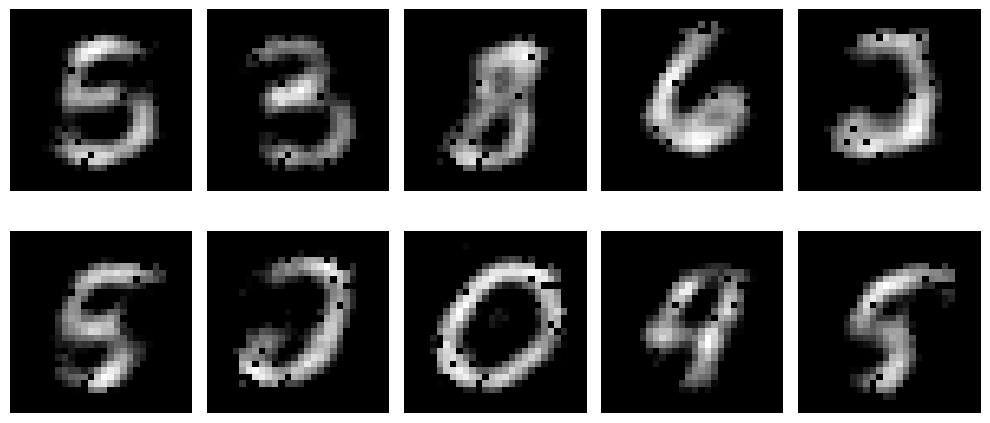

Lambda:  0.125
[15680 15700 31380 32164]
Removed 10168 params


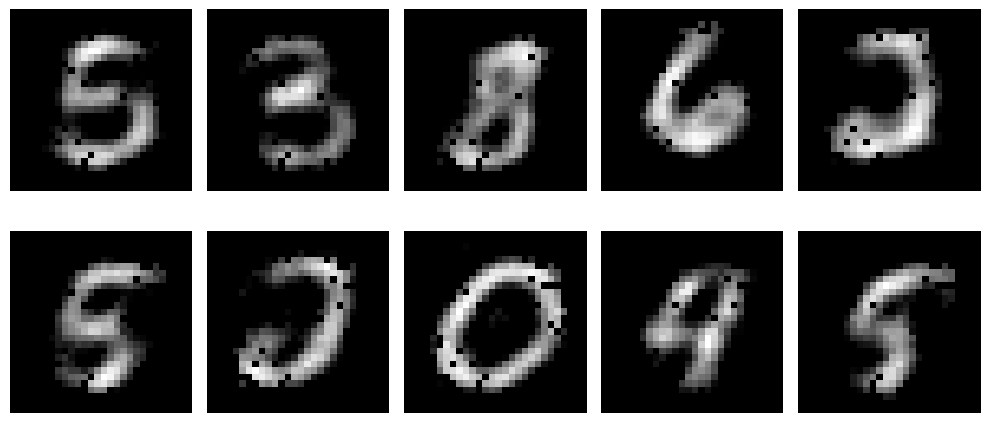

Lambda:  0.25
[15680 15700 31380 32164]
Removed 10889 params


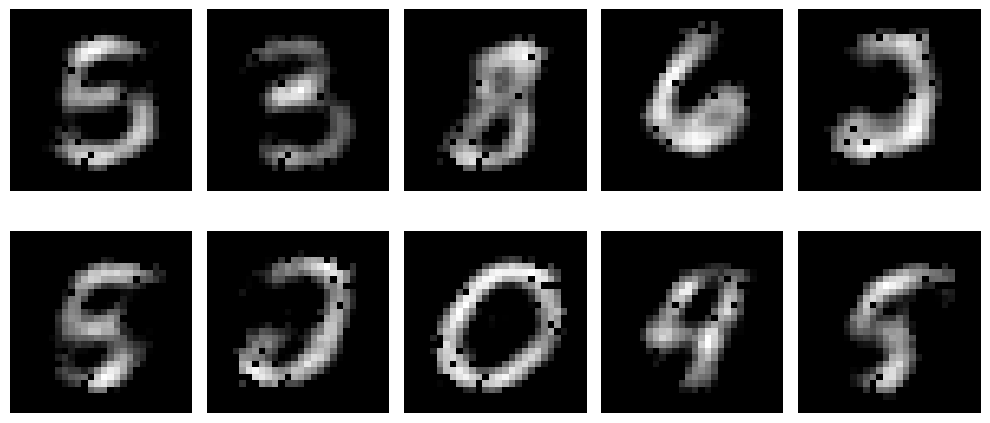

Lambda:  0.375
[15680 15700 31380 32164]
Removed 11308 params


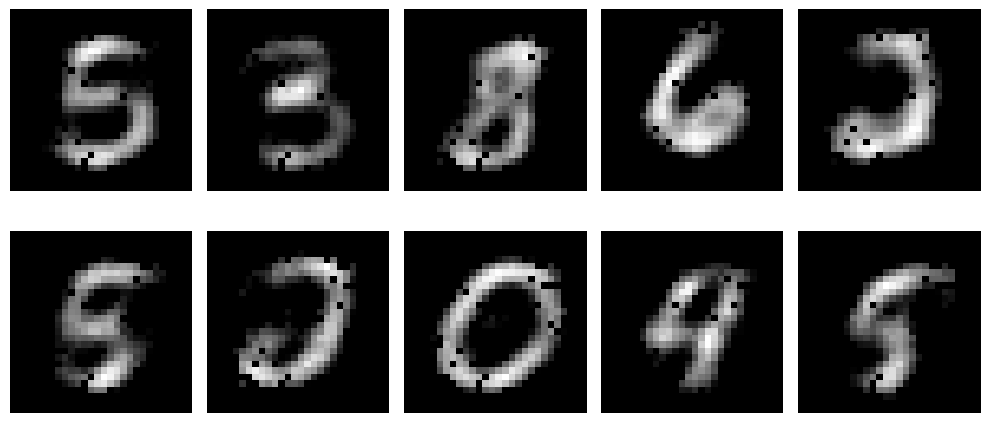

Lambda:  0.5
[15680 15700 31380 32164]
Removed 11689 params


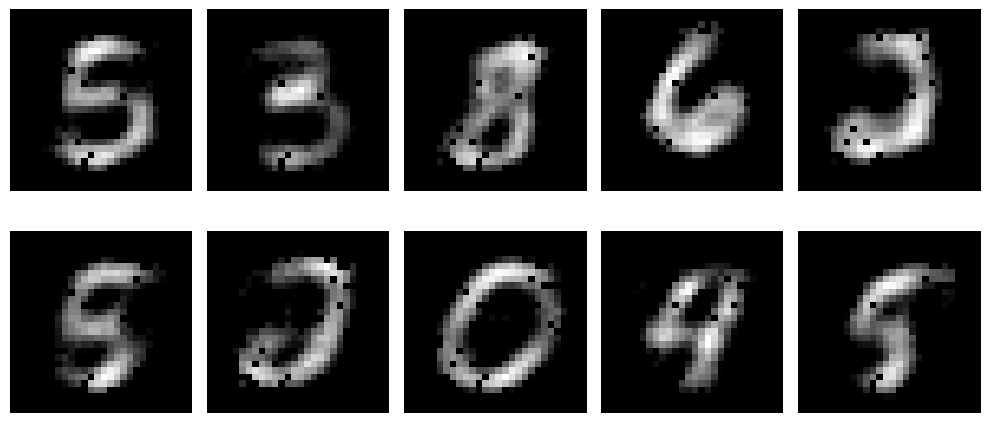

Lambda:  0.625
[15680 15700 31380 32164]
Removed 12043 params


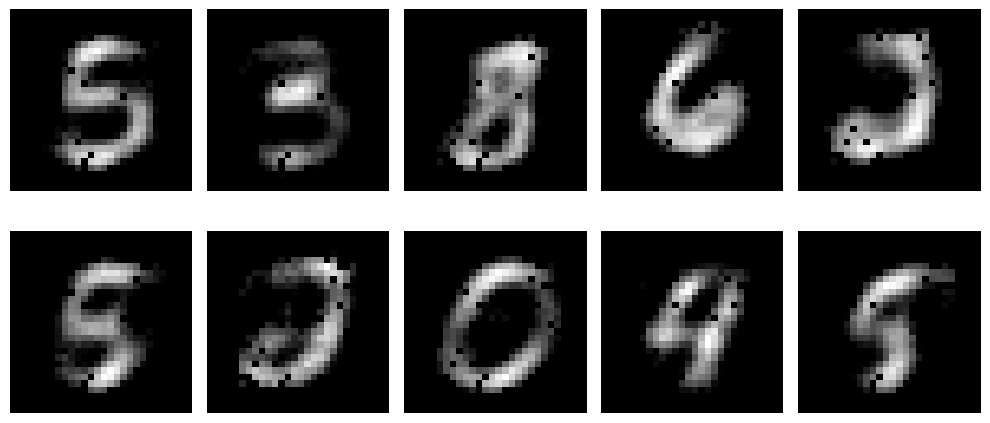

Lambda:  0.75
[15680 15700 31380 32164]
Removed 12317 params


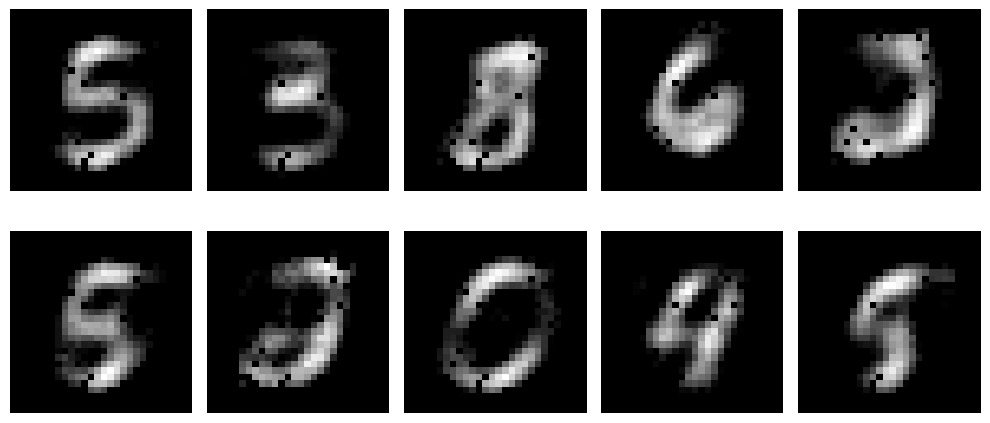

Lambda:  0.875
[15680 15700 31380 32164]
Removed 12610 params


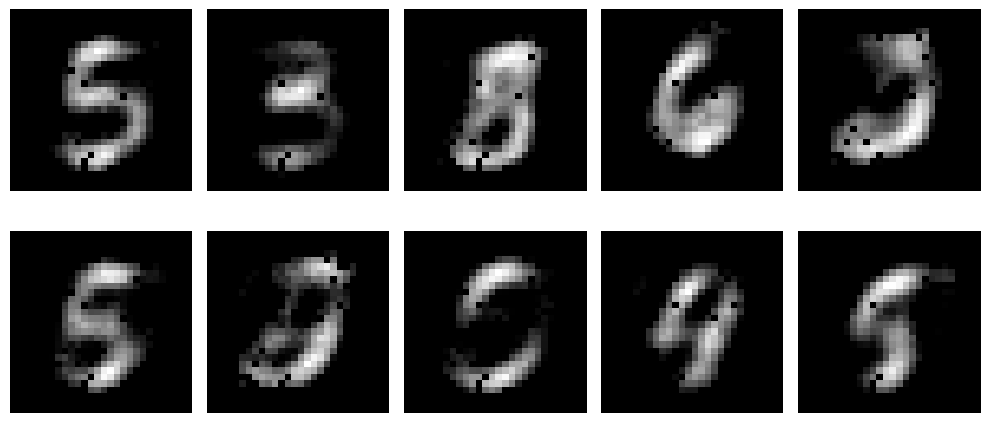

Lambda:  1.0
[15680 15700 31380 32164]
Removed 12979 params


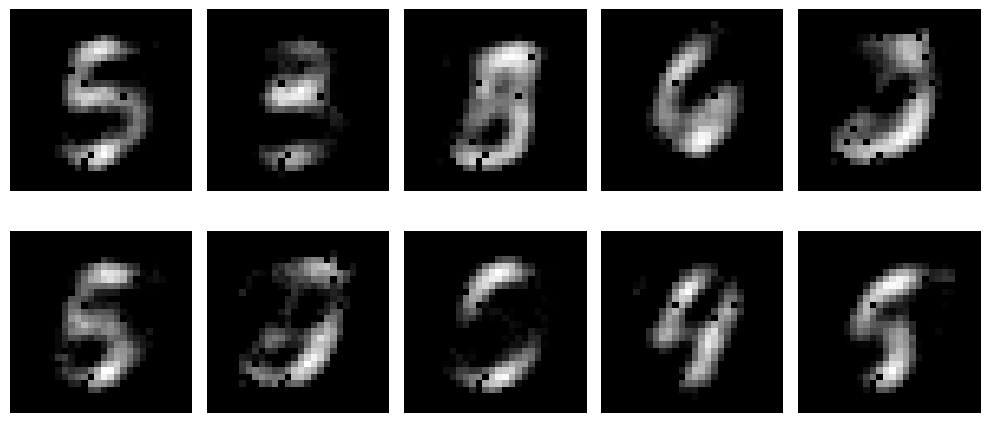

Lambda:  1.125
[15680 15700 31380 32164]
Removed 13390 params


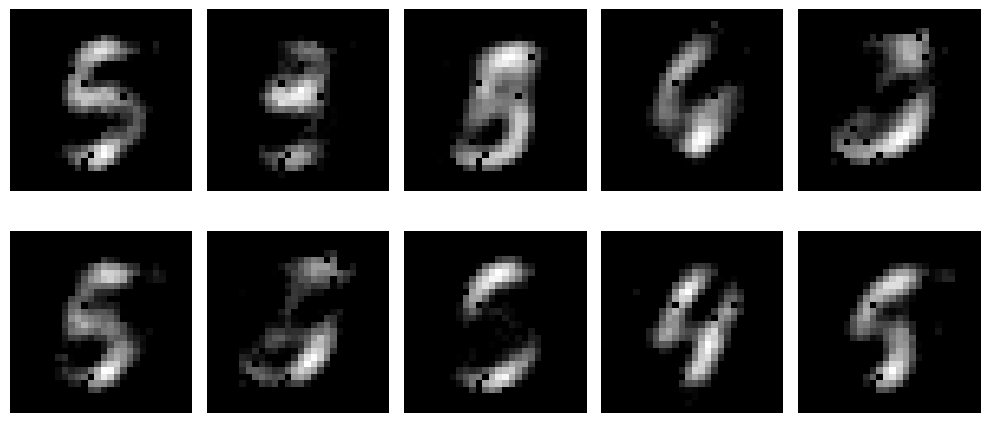

Lambda:  1.25
[15680 15700 31380 32164]
Removed 13879 params


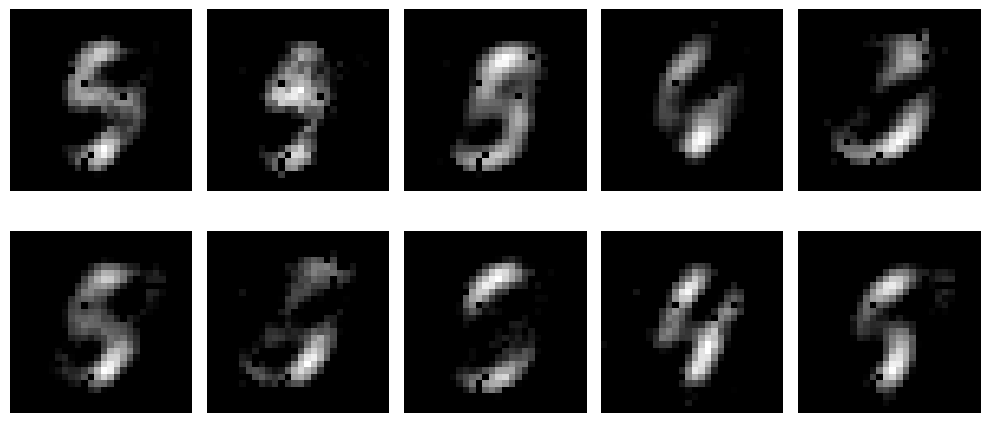

Lambda:  1.375
[15680 15700 31380 32164]
Removed 14313 params


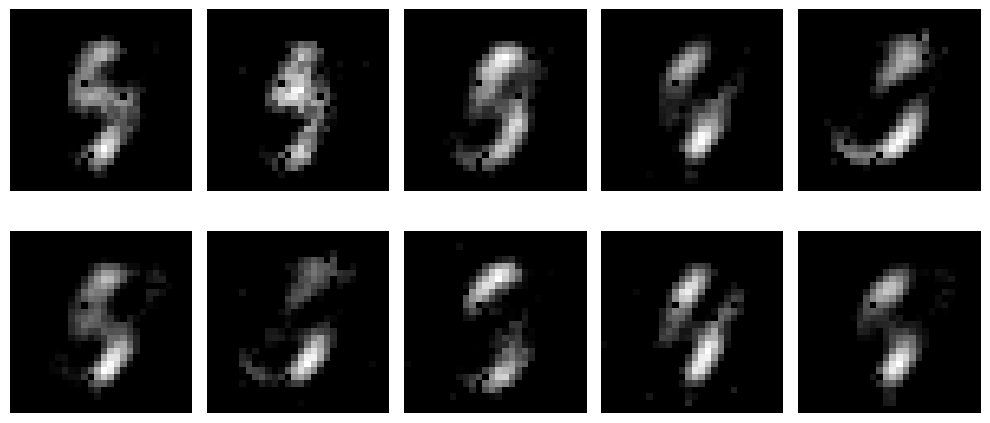

Lambda:  1.5
[15680 15700 31380 32164]
Removed 14744 params


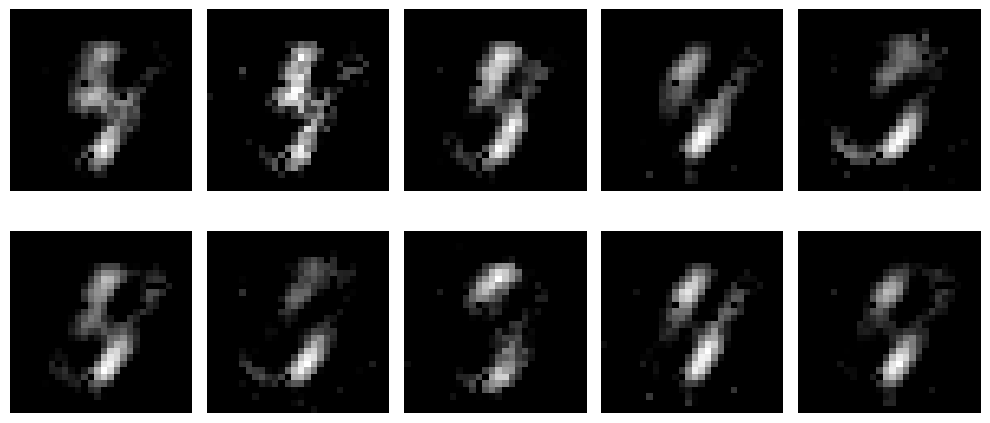

Lambda:  1.625
[15680 15700 31380 32164]
Removed 15103 params


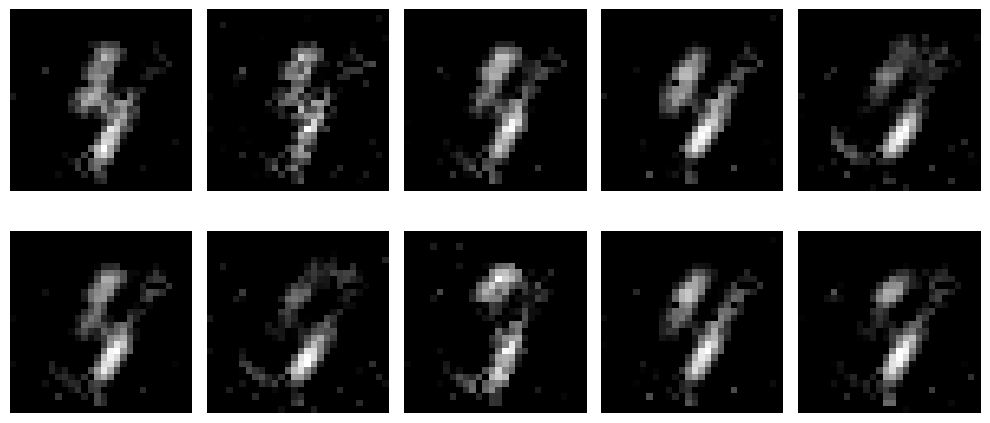

Lambda:  1.75
[15680 15700 31380 32164]
Removed 15386 params


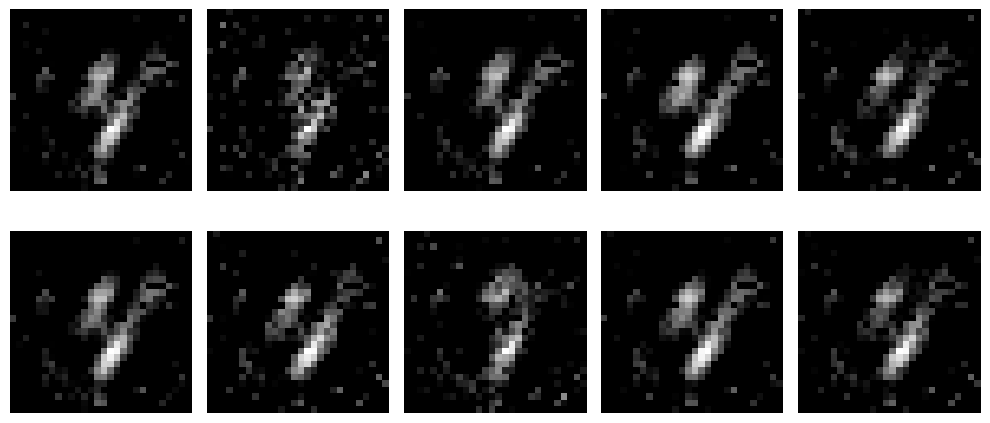

Lambda:  1.875
[15680 15700 31380 32164]
Removed 15541 params


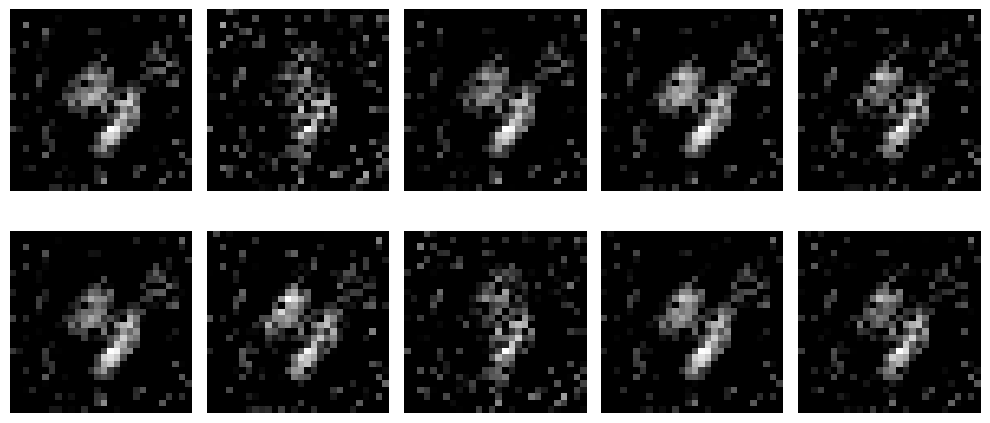

Lambda:  2.0
[15680 15700 31380 32164]
Removed 15615 params


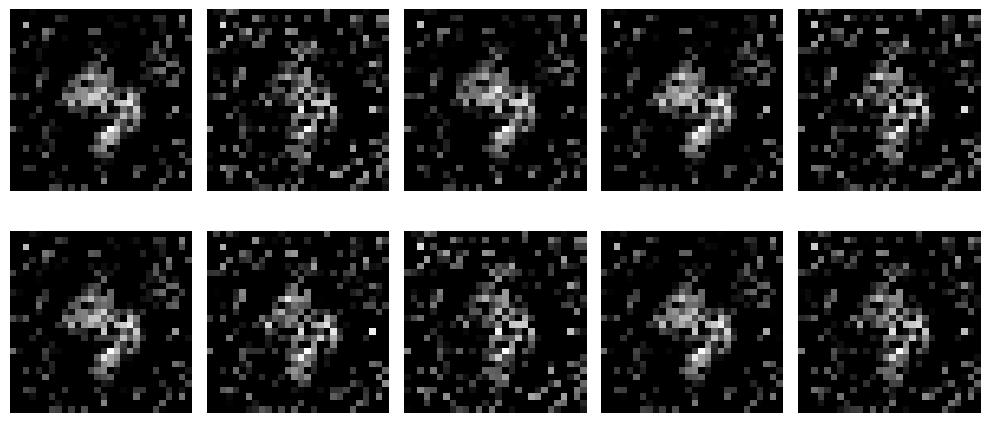

Lambda:  2.125
[15680 15700 31380 32164]
Removed 15658 params


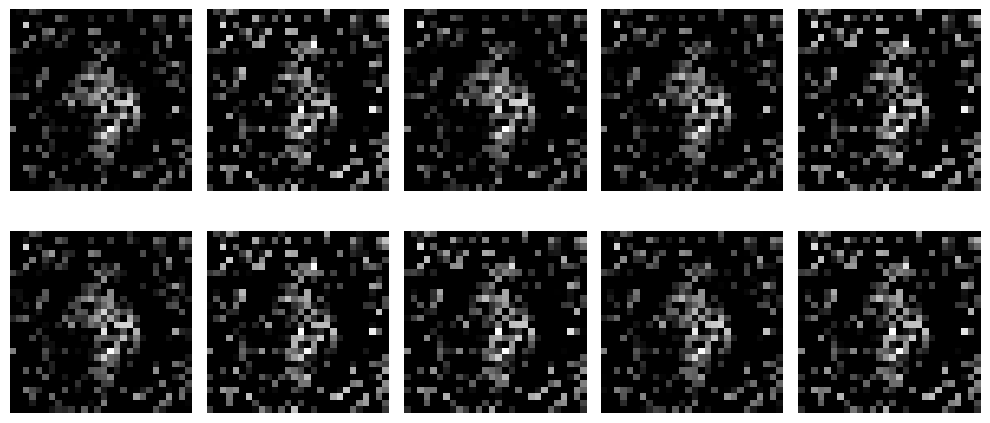

Lambda:  2.25
[15680 15700 31380 32164]
Removed 15678 params


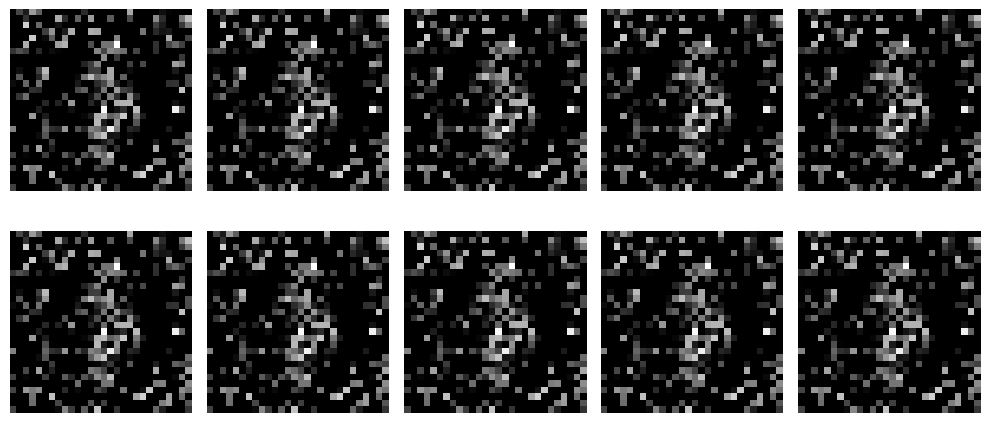

Lambda:  2.375
[15680 15700 31380 32164]
Removed 15680 params


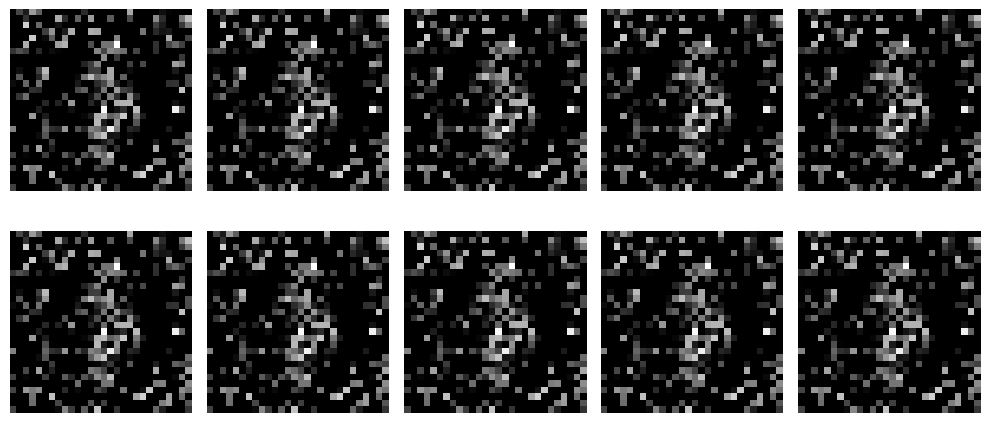

In [100]:
no_sloppy = []
fisher_kl_divs = []
kl = torch.nn.MSELoss()

for cutoff in range(20):
    cutoff = cutoff/8
    print('Lambda: ', cutoff)
    # Create a backup of the original model before pruning
    model_clone = copy.deepcopy(model)
    sloppy_rows = fisher_transform.get_sloppy_rows(fim, model_clone.autoencoder, cutoff=cutoff)
    _, removed_params = fisher_transform.zero_sloppy_params(fim, sloppy_rows, model_clone.autoencoder)
    no_sloppy.append(removed_params)
    stiff_autoencoded_batch = [model_clone.autoencoder(batch_0[i]) for i in range(10)]
    fisher_kl_divs.append(np.mean([kl(model_clone.autoencoder(batch_0[i]), batch_0[i]).detach().numpy() for i in range(10)]))
    plot_batch(stiff_autoencoded_batch, f'plots/autoencoded_stiff_cutoff_{cutoff}_rem_{removed_params}_of_15680_params.pdf')

In [101]:
# Check number of sloppy rows in each iteration
print('Sloppy directions: ', no_sloppy)

print('Average batch KL divergences ', fisher_kl_divs)

Sloppy directions:  [5496, 10168, 10889, 11308, 11689, 12043, 12317, 12610, 12979, 13390, 13879, 14313, 14744, 15103, 15386, 15541, 15615, 15658, 15678, 15680]
Average batch KL divergences  [0.03619113, 0.036344178, 0.03687676, 0.037634153, 0.039215654, 0.04195165, 0.04564725, 0.050673507, 0.054719824, 0.060925625, 0.07080993, 0.08196928, 0.08947408, 0.09760891, 0.109063305, 0.1128392, 0.11685307, 0.11970159, 0.12106955, 0.12106955]


Removed 5496 params


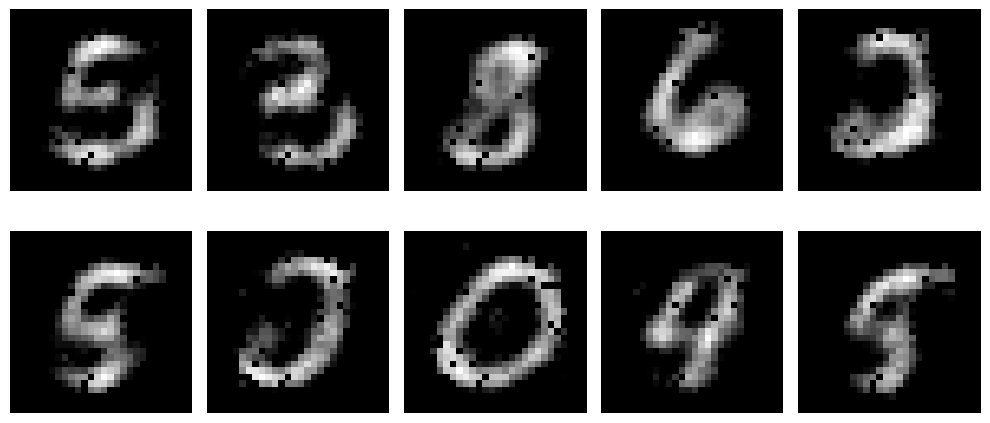

Removed 10168 params


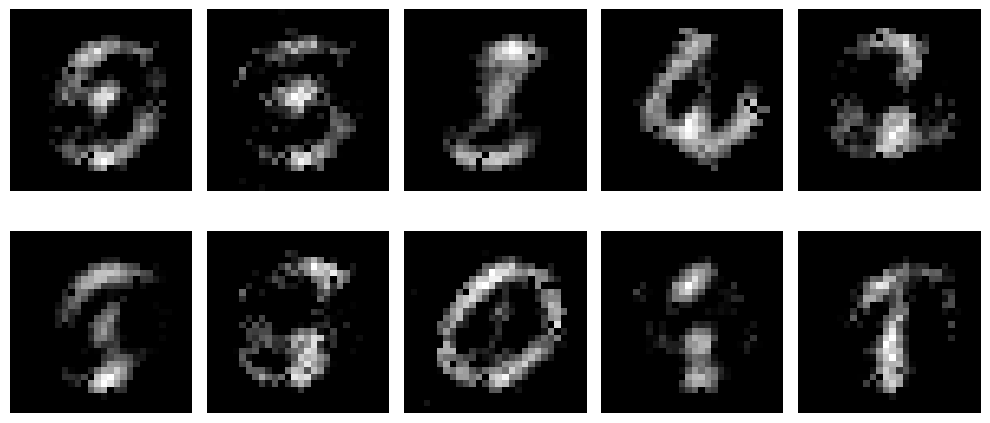

Removed 10889 params


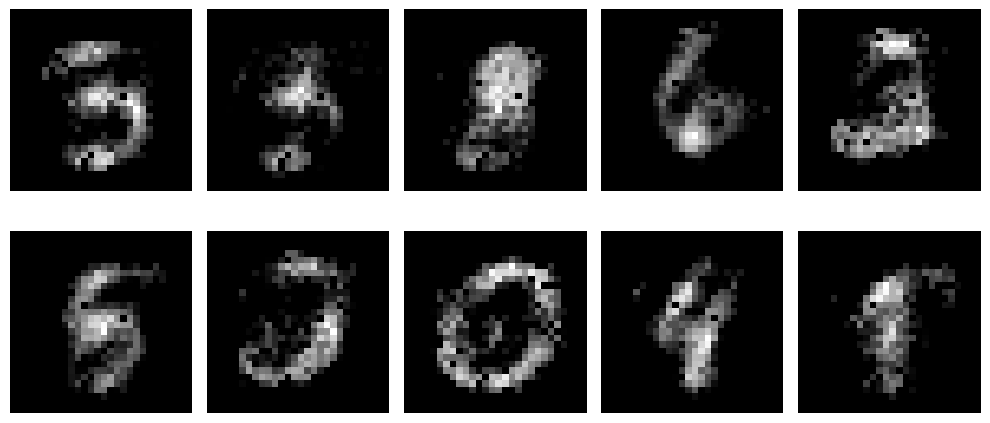

Removed 11308 params


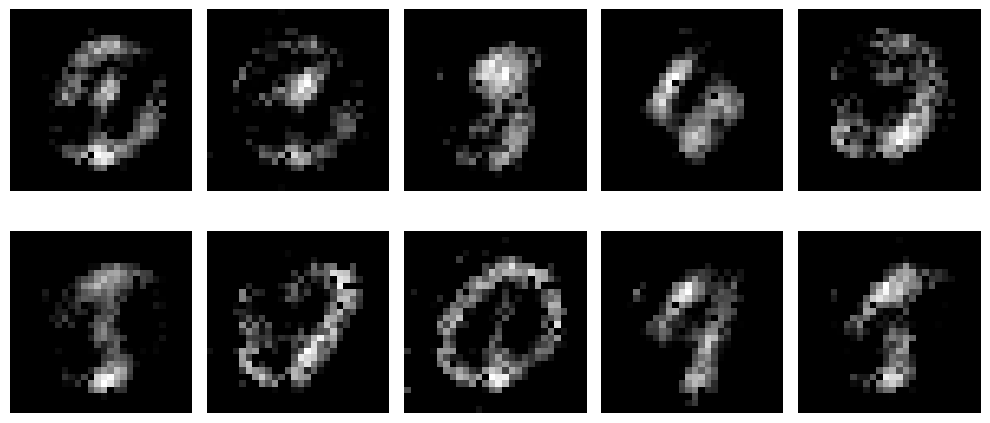

Removed 11689 params


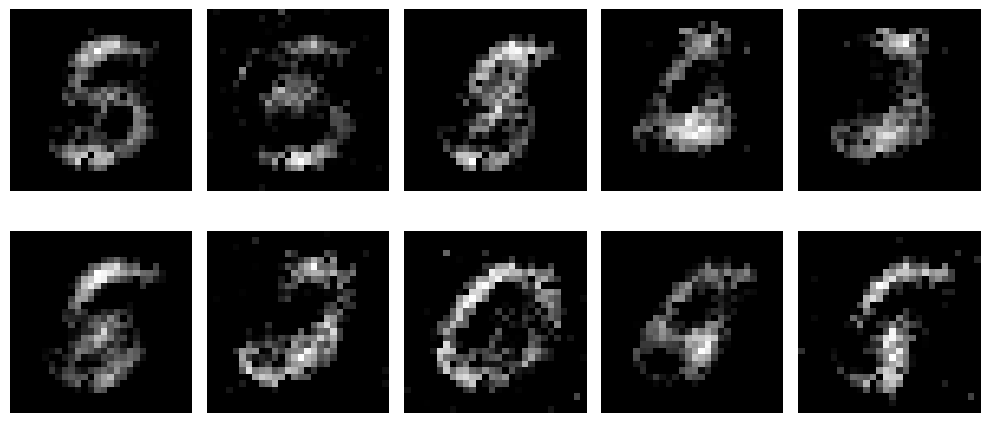

Removed 12043 params


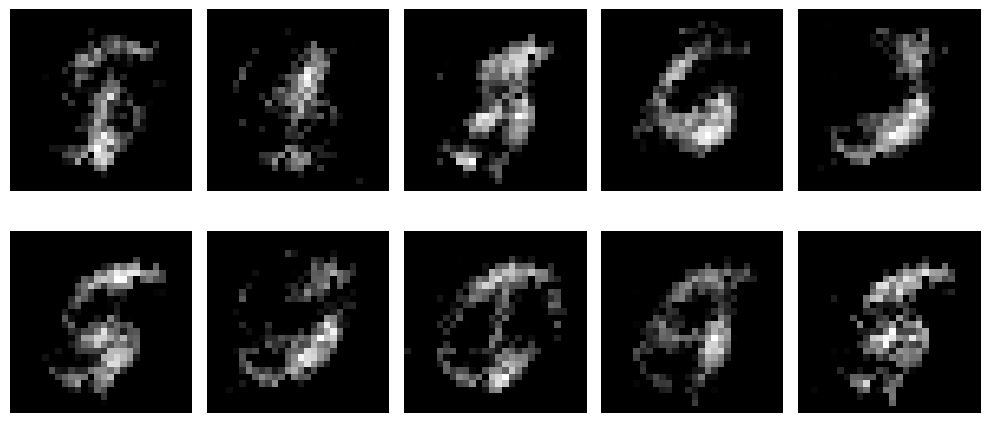

Removed 12317 params


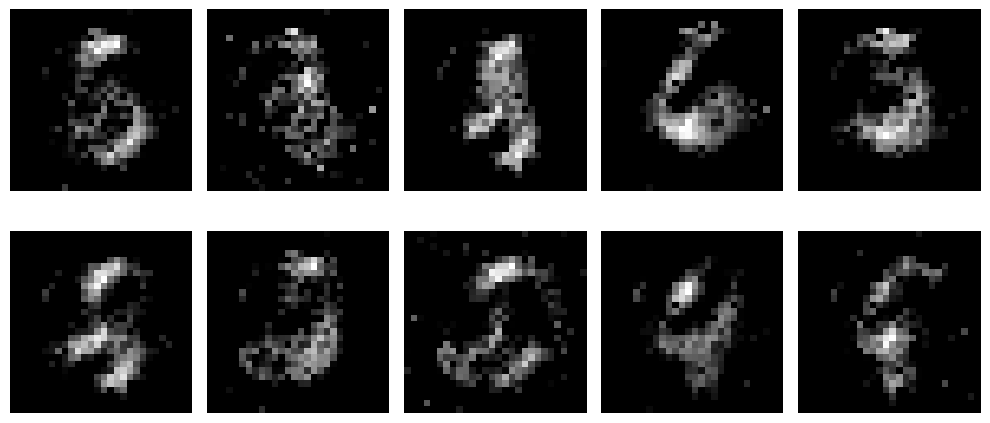

Removed 12610 params


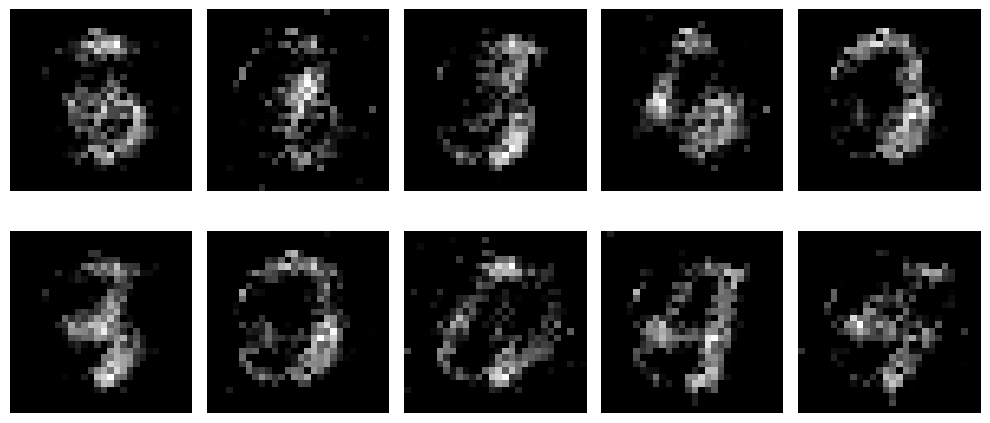

Removed 12979 params


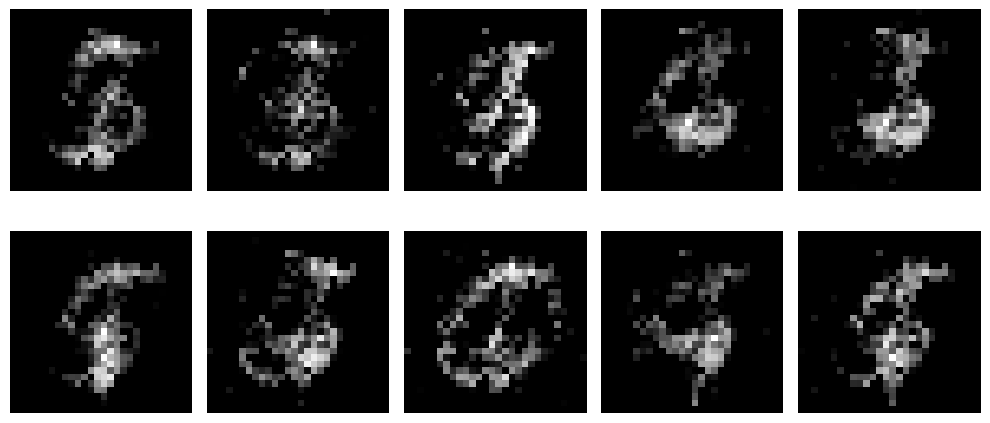

Removed 13390 params


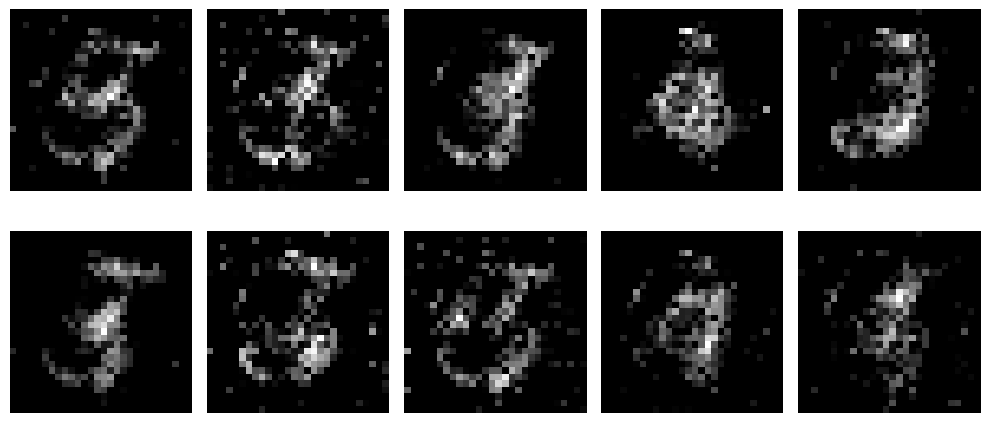

Removed 13879 params


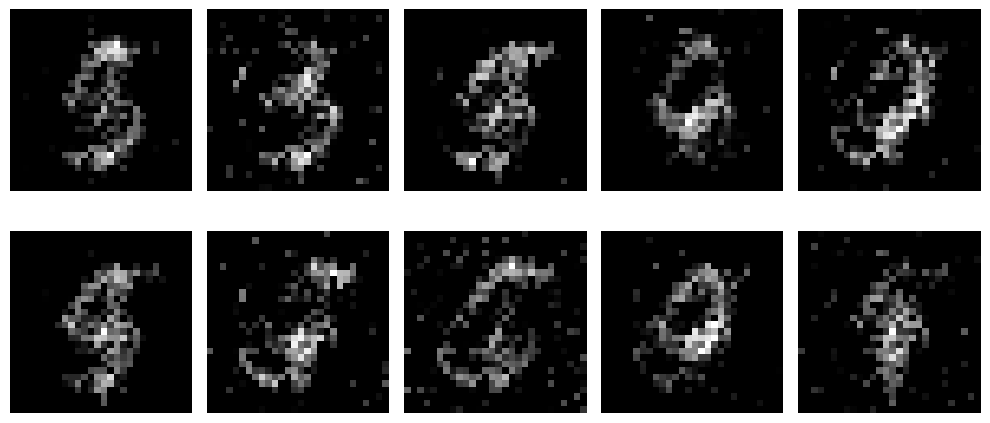

Removed 14313 params


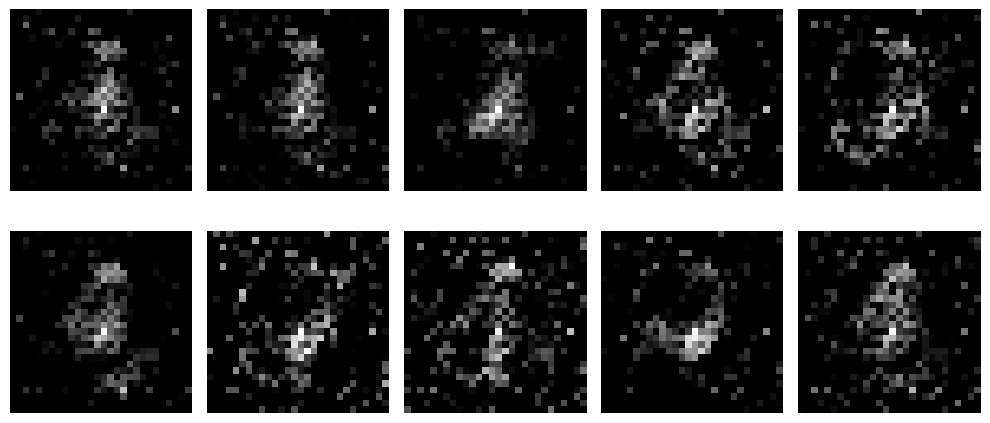

Removed 14744 params


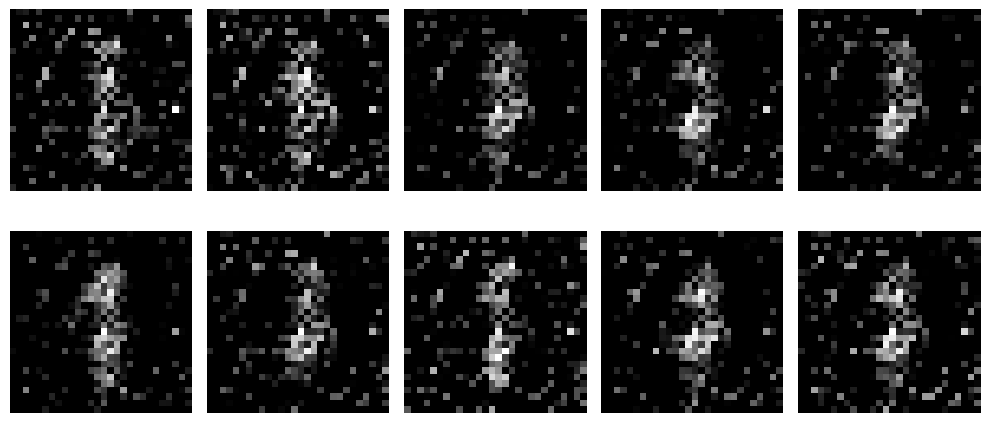

Removed 15103 params


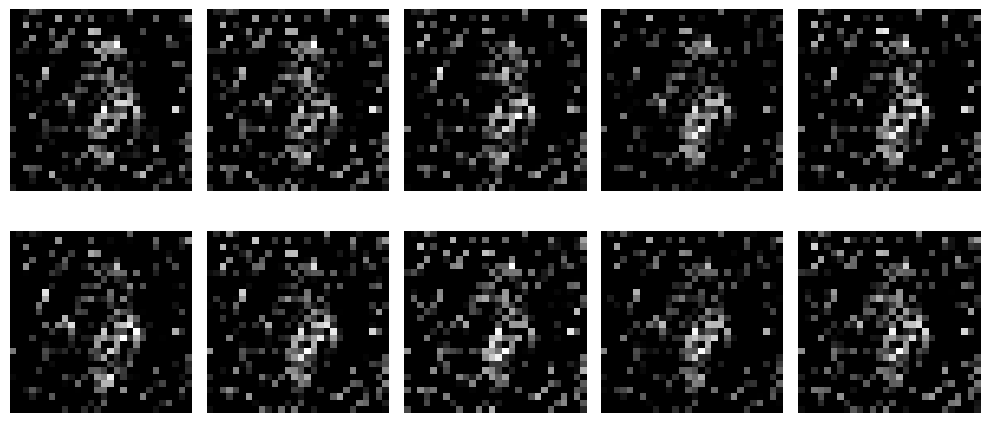

Removed 15386 params


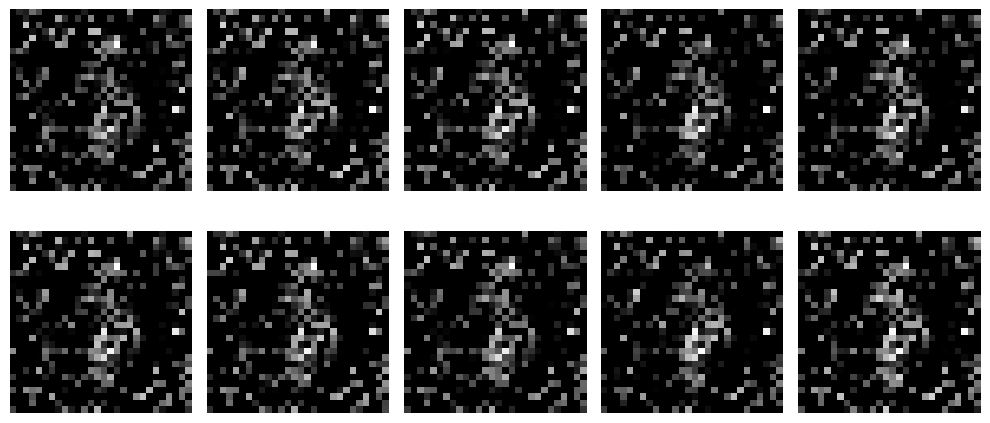

Removed 15541 params


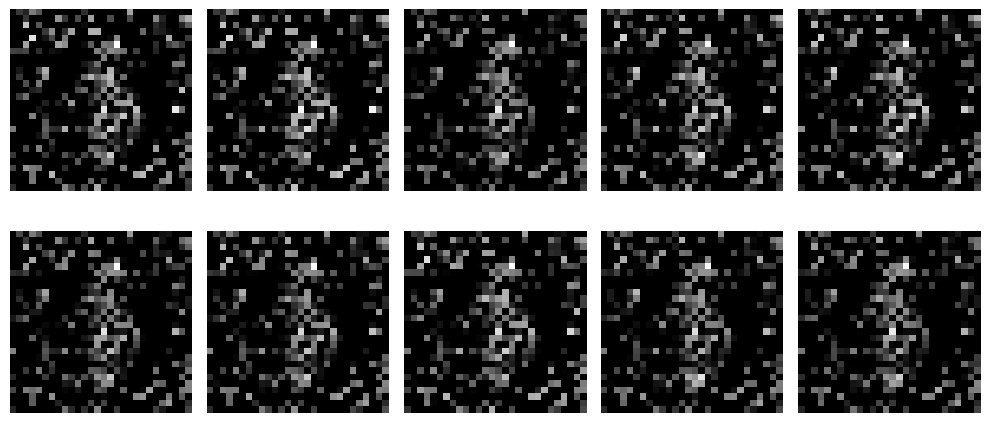

Removed 15615 params


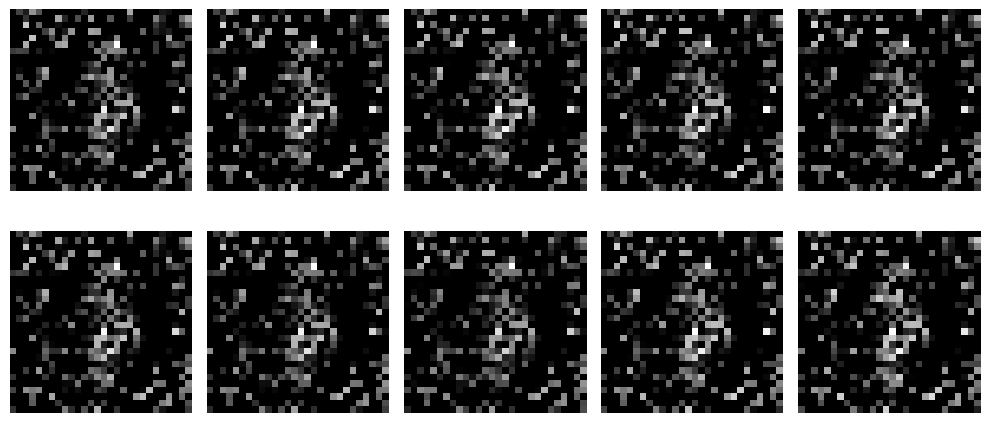

Removed 15658 params


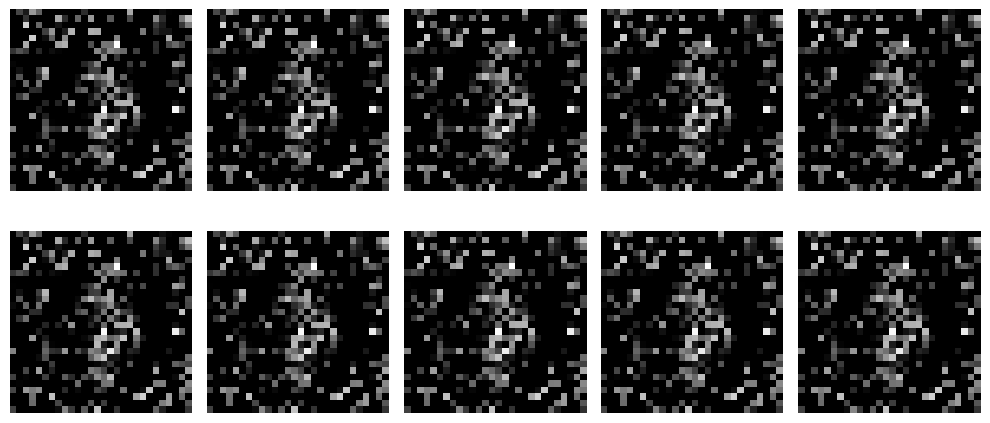

Removed 15678 params


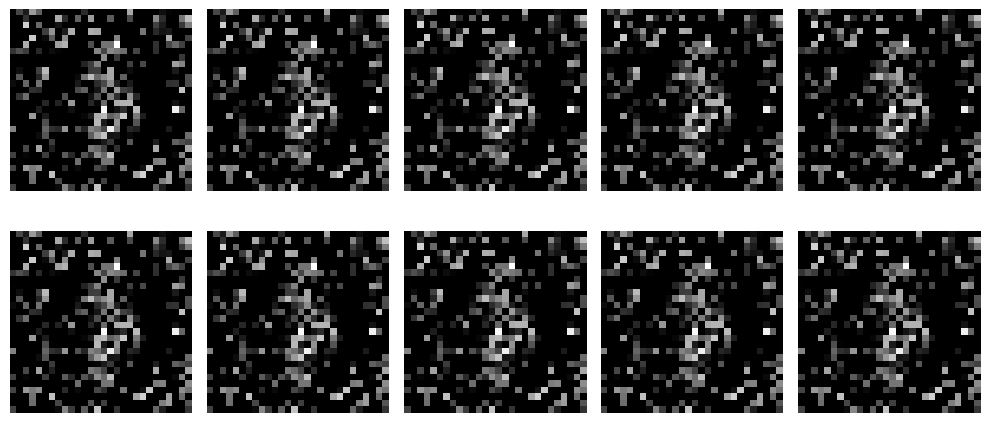

Removed 15680 params


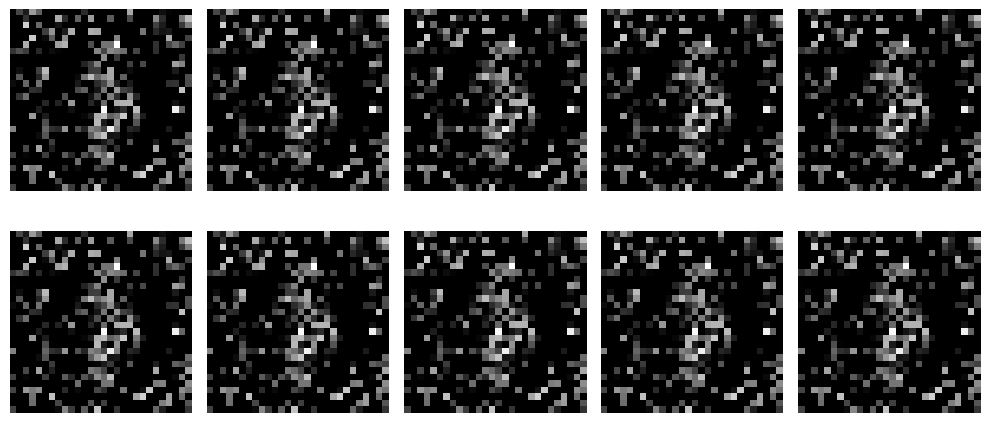

In [102]:
random_kl_divs = []

for to_remove in no_sloppy:
    # Create a backup of the original model before pruning
    model_clone = copy.deepcopy(model)
    sloppy_rows = torch.tensor(np.random.choice(15680, size=to_remove, replace=False))
    _, removed_params = fisher_transform.zero_sloppy_params(fim, sloppy_rows, model_clone.autoencoder)
    random_kl_divs.append(np.mean([kl(model_clone.autoencoder(batch_0[i]), batch_0[i]).detach().numpy() for i in range(10)]))
    stiff_autoencoded_batch = [model_clone.autoencoder(batch_0[i]) for i in range(10)]
    plot_batch(stiff_autoencoded_batch, f'plots/unif/random_prune_rem_{removed_params}_of_15680_params.pdf')

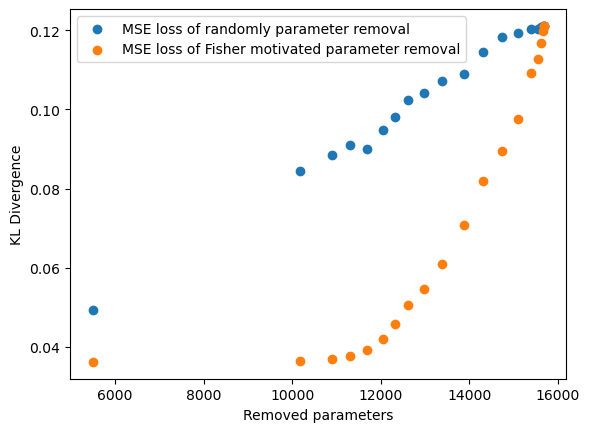

In [112]:
# plt.figure()
plt.scatter(no_sloppy, random_kl_divs, label='MSE loss of randomly parameter removal')
plt.scatter(no_sloppy, fisher_kl_divs, label='MSE loss of Fisher motivated parameter removal')
plt.xlabel('Removed parameters')
plt.ylabel('KL Divergence')
plt.legend()
plt.savefig('plots/MSE_loss_random_vs_fisher.pdf')
# plt.scatter(range(len(fisher_kl_divs)), np.array(random_kl_divs) - np.array(fisher_kl_divs))
# fisher_kl_divs

In [121]:
no_sloppy.index(15386)

14

In [124]:
for i in [1, 10, 11, 14]:
    print(fisher_kl_divs[i])

0.036344178
0.07080993
0.08196928
0.109063305
